<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

     |████████████████████████████████| 204 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 2.2 MB/s 


In [2]:
import fastai
fastai.__version__

'2.7.7'

In [3]:
# import colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [5]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
comp = 'feedback-prize-effectiveness'
path = setup_comp(comp)
path

100%|██████████| 8.13M/8.13M [00:00<00:00, 164MB/s]

Path('feedback-prize-effectiveness')

In [7]:
from fastai.text.all import *
set_seed(32)

In [8]:
# create data loaders
df = pd.read_csv(path/'train.csv')
dls = TextDataLoaders.from_df(df, text_col='discourse_text',
                              label_col='discourse_effectiveness')
dls.show_batch(max_n=3)

,text,category
0,xxbos xxmaj you can search the website up so that you can finished it the assignment to handle it in to your teacher if you missing anything from your others class you can finished with your others class you have with your xxunk . xxmaj if you stuck on the question go asked your teacher to helped you out now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen show up and now go to the website that is on your paper to finished on your assignment on your homework . \n\n xxmaj first now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen is done . xxmaj now listen,Ineffective
1,xxbos xxup the xxup canidates xxup are xxup all xxup running xxup for xxup president xxup and xxup one xxup person xxup has xxup to xxup choose xxup from xxup the xxup canidates xxup how xxup it xxup will xxup work xxup and xxup that xxup they xxup will xxup pick xxup the xxup electoral xxup voters xxup to xxup vote xxup and xxup that s xxup how xxup they xxup would xxup vote ▁ xxup they xxup select a xxup person xxup every xxup four xxup years xxup and xxup they xxup assign xxup them xxup for xxup the xxup electors xxup they xxup are xxup often xxup chose xxup by xxup xxunk ▁ xxup you xxup will xxup also xxup help xxup them xxup vote xxup because xxup they xxup vote xxup after xxup everyone xxup else \n\n xxup after xxup the xxup president xxup election xxup the,Ineffective
2,"xxbos xxmaj today my xxunk xxmaj don xxmaj reist xxunk me to come with him to the xxmaj seagoing xxmaj cowboys program he wanted me to go and tought about and xxmaj want to go mainly becaues i was 18 and out of school and i can get dafted to the army . \n\n xxmaj don xxunk me that since the war was over we go to this other country and help them out a little sice it was a big mess over . \n\n xxmaj it was xxmaj august 14 , they reported us at xxmaj new xxmaj orleans . xxmaj when we got there they were giving out thing to do before the ship got there they said for me go get more peole to do this program and i did . i walked down to the xxunk got a big line of people the fun thing was",Ineffective


SuggestedLRs(valley=0.0063095735386013985, slide=0.015848932787775993)

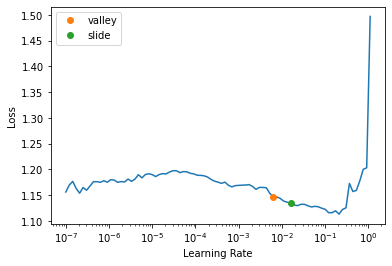

In [9]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy,F1Score(average='weighted')]).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

In [10]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.901478,0.916848,0.570515,0.503314,00:47


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.829376,0.828450,0.624779,0.569051,01:03
1,0.794410,0.838306,0.637427,0.580799,01:03
2,0.750694,0.779697,0.658915,0.627296,01:03
3,0.668754,0.794783,0.655243,0.626381,01:03
4,0.586744,0.818035,0.648851,0.628935,01:03


In [11]:
learn.export('basic_text_learner.pkl')

## Test submission

In [12]:
test_df = pd.read_csv(path/'test.csv')
test_df.rename(columns = {'discourse_text':'text'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   discourse_id    10 non-null     object
 1   essay_id        10 non-null     object
 2   text            10 non-null     object
 3   discourse_type  10 non-null     object
dtypes: object(4)
memory usage: 448.0+ bytes


In [13]:
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,"xxbos xxmaj taking other peoples advice and doing what they say may lead to a great outcome . xxmaj when you receive other opinions whether they are good or bad you will be able to look at them from a different point of view . xxmaj for example , xxmaj when a group of people give you advice on yourself , you then know how they look at you as a person . xxmaj everyone looks at certain things from a different xxunk . xxmaj how someone else looks at it may be how its supposed to be viewed in life ."
1,"xxbos xxmaj everyone is different and may have more experience than you . xxmaj seeking other peoples opinion can cause you to gain a new skill or lesson . xxmaj for example , someones advice could teach you how to do something the correct way . xxmaj many people are very different and have experience different things in life . xxmaj seeking advice from others can teach you a lot . xxmaj we all learn from our mistakes in life , by sharing your past experiences you may prevent someone else from making the same mistake ."
2,xxbos xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make choosing an option less difficult and more easier . xxmaj the information that you receive from others may have a special meaning in the future . xxmaj other peoples opinion can make a person feel confident in making the right choice .
3,xxbos xxmaj you can learn from others experiences by seeking the advice that someone give you . xxmaj making decisions can cause stress on a person . xxmaj relating to someones advice may higher your self - esteem because you no longer feel left out . xxmaj ask others for advice when making a difficult decision . xxmaj when you seek others opinion more opportunities are available fro yourself .
4,xxbos xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself .
5,xxbos xxmaj seeking multiple opinions can help a person make a better choice
6,xxbos xxmaj seeking others opinion can be very helpful and beneficial .
7,xxbos a great chance to learn something new
8,xxbos can be very helpful and beneficial .


In [14]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[0.3726, 0.6210, 0.0063],
        [0.8379, 0.1274, 0.0347],
        [0.5669, 0.1175, 0.3156],
        [0.5168, 0.2806, 0.2027],
        [0.5669, 0.1175, 0.3156],
        [0.5190, 0.4721, 0.0088],
        [0.4075, 0.5849, 0.0076],
        [0.7450, 0.1183, 0.1367],
        [0.7001, 0.2276, 0.0724],
        [0.3686, 0.6259, 0.0055]])

In [15]:
# column names for probabilities
probs_df = pd.DataFrame(probs.numpy(),columns = dls.vocab[1])
probs_df

,Adequate,Effective,Ineffective
0,0.372643,0.621020,0.006337
1,0.837884,0.127431,0.034685
2,0.566875,0.117496,0.315629
3,0.516776,0.280555,0.202669
4,0.566875,0.117496,0.315629
5,0.519042,0.472132,0.008827
6,0.407504,0.584863,0.007633
7,0.744986,0.118278,0.136736
8,0.700060,0.227582,0.072359
9,0.368638,0.625851,0.005511


In [16]:
probs_df["discourse_id"] = test_df["discourse_id"]
probs_df.to_csv('submission.csv', index=False)
!head submission.csv

Adequate,Effective,Ineffective,discourse_id
0.37264305,0.6210199,0.006336979,a261b6e14276
0.8378836,0.12743142,0.034685053,5a88900e7dc1
0.56687474,0.11749642,0.31562886,9790d835736b
0.51677597,0.28055495,0.20266904,75ce6d68b67b
0.56687474,0.11749642,0.31562886,93578d946723
0.51904184,0.47213167,0.008826564,2e214524dbe3
0.40750358,0.5848631,0.007633227,84812fc2ab9f
0.7449863,0.11827753,0.13673617,c668ff840720
0.70005983,0.22758153,0.07235862,739a6d00f44a


In [17]:
# not working for this competetion
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'initial', comp)

In [18]:
# if not iskaggle:
#     push_notebook('saan', comp,
#                   title='Feedback effeciveness  initial model',
#                   file='/content/drive/MyDrive/Colab Notebooks/basic_model.ipynb',
#                   competition=comp, private=True, gpu=True)